In [1]:
!python -V

Python 3.10.9


In [2]:
import pandas as pd

In [14]:
import pickle

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
import numpy as np

In [18]:
df = pd.read_parquet('green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [21]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred)

96.80198150112747

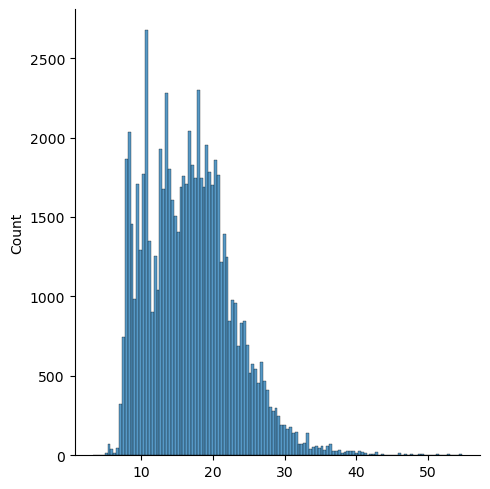

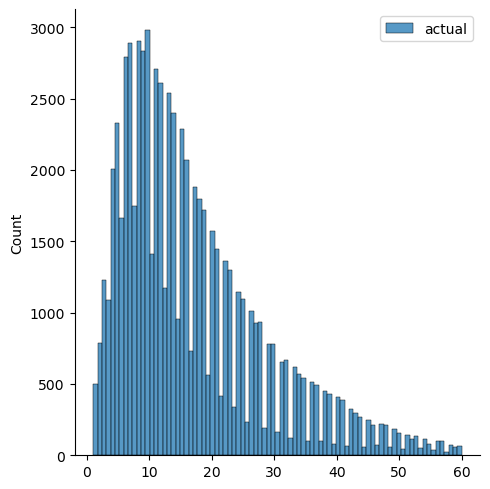

In [24]:
sns.distplot(y_pred, label='prediction')
sns.displot(y_train, label='actual')

plt.legend()

In [25]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [26]:
df_train = read_dataframe('green_tripdata_2021-01.parquet')
df_val = read_dataframe('green_tripdata_2021-02.parquet')

In [27]:
len(df_train), len(df_val)

(73908, 61921)

In [28]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [29]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [30]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [32]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred)

60.19766167607019

In [35]:
with open('models_lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [37]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred)

124.70805194645156